In [1]:
#Load relevant libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
import geopandas as gpd
import datetime as dt
from scipy.spatial.distance import cdist
from sklearn.impute import KNNImputer
from shapely.geometry import Point, Polygon
warnings.filterwarnings('ignore')

In [2]:
#Load data for cities, fires 
cities = pd.read_csv('precipitation_temp_city/city_info.csv',index_col=0)
fires = pd.read_csv('Monitoring_Trends_in_Burn_Severity_Fire_Occurrence_Locations__Feature_Layer_.csv')

In [3]:
cities.loc[cities['Name']== 'Winnemucca']

,Name,ID,Lat,Lon,Stn.Name,Stn.stDate,Stn.edDate
183,Winnemucca,USW00024128,40.9017,-117.8081,WINNEMUCCA WB CITY,1878-01-01,1949-09-14
184,Winnemucca,USW00024128,40.9017,-117.8081,WINNEMUCCA MUNICIPAL ARPT,1949-09-15,2017-12-31


In [4]:
#load relevant data for each city of choice 

Winnemucca_w = pd.read_csv('precipitation_temp_city/USW00024128.csv', index_col=0).reset_index(drop=True)

In [5]:
#convert all Date columns to datetime 


Winnemucca_w['Date'] = pd.to_datetime(Winnemucca_w['Date'])

In [6]:

def drop_dates(city):
    city = city[(city['Date'] > '1983-12-31')]
    city = city[(city['Date'] < '2018-01-01')] 
    city = city.reset_index(drop=True)
    return city



In [7]:
Winnemucca_w = drop_dates(Winnemucca_w)


In [8]:
#Look at null values in each dataset


print(Winnemucca_w.isna().sum())

Date    0
tmax    0
tmin    0
prcp    0
dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

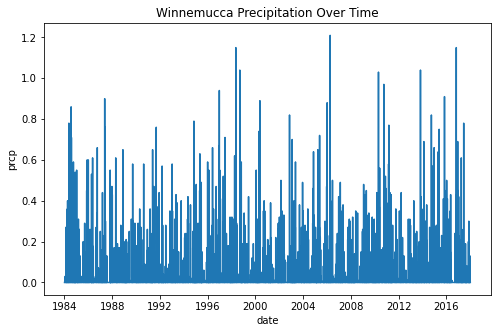

In [9]:
plt.figure(figsize=(8,5))
sns.lineplot('Date', 'prcp', data = Winnemucca_w)
plt.title('Winnemucca Precipitation Over Time')
plt.xlabel('date')
plt.ylabel('prcp')
plt.show
    

<function matplotlib.pyplot.show(close=None, block=None)>

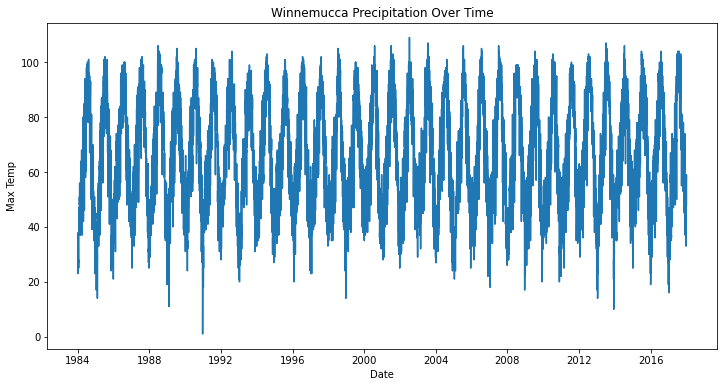

In [10]:
plt.figure(figsize=(12,6))
sns.lineplot('Date', 'tmax', data = Winnemucca_w)
plt.title('Winnemucca Precipitation Over Time')
plt.xlabel('Date')
plt.ylabel('Max Temp')
plt.show
    

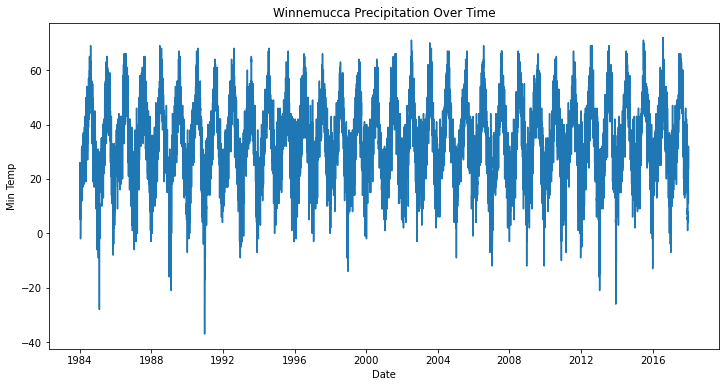

In [11]:
plt.figure(figsize=(12,6))
sns.lineplot('Date', 'tmin', data = Winnemucca_w)
plt.title('Winnemucca Precipitation Over Time')
plt.xlabel('Date')
plt.ylabel('Min Temp')
plt.show()

In [12]:
#remove unnecessary columns from the fire data 
fires = fires[['FIRE_ID','LATITUDE', 'LONGITUDE', 'FIRE_TYPE','IG_DATE', 'ACRES']]
#remove all fires that are not wildfires
fires = fires.loc[fires['FIRE_TYPE'] == 'Wildfire']
fires.head()

,FIRE_ID,LATITUDE,LONGITUDE,FIRE_TYPE,IG_DATE,ACRES
0,TX3187009562420110904,31.845,-95.639,Wildfire,2011/09/04 00:00:00+00,1606
1,TX3175209496120110904,31.717,-94.959,Wildfire,2011/09/04 00:00:00+00,8344
2,TX3161209566220110905,31.609,-95.673,Wildfire,2011/09/05 00:00:00+00,1121
3,TX3165109516420110911,31.649,-95.147,Wildfire,2011/09/11 00:00:00+00,2146
4,CA3772812166319980829,37.728,-121.663,Wildfire,1998/08/29 00:00:00+00,1108


In [13]:
#convert IG_DATE to datetime with YYYY-MM-DD Format labeled 'Date'

fires['Year'] = pd.DatetimeIndex(fires['IG_DATE']).year
fires['Month'] = pd.DatetimeIndex(fires['IG_DATE']).month
fires['Day'] = pd.DatetimeIndex(fires['IG_DATE']).day
fires['Date'] = pd.to_datetime([f'{y}-{m}-{d}' for y, m,d in zip(fires.Year, fires.Month, fires.Day)])
fires.drop(['IG_DATE', 'Month', 'Year', 'Day'], axis=1, inplace=True)
fires = fires.reset_index(drop=True)

In [14]:
Winn_fires = fires.loc[fires.LATITUDE < 41.9017]
Winn_fires = Winn_fires.loc[Winn_fires.LATITUDE > 39.9017]
Winn_fires = Winn_fires.loc[Winn_fires.LONGITUDE > -118.8081]
Winn_fires = Winn_fires.loc[Winn_fires.LONGITUDE < -116.8081]
Winn_fires.reset_index(inplace=True, drop=True)

In [15]:
Winn_fires.head()

,FIRE_ID,LATITUDE,LONGITUDE,FIRE_TYPE,ACRES,Date
0,NV4054511701320060822,40.545,-117.013,Wildfire,3508,2006-08-22
1,NV4189711769519870813,41.897,-117.695,Wildfire,1316,1987-08-13
2,NV4185511758419890703,41.855,-117.584,Wildfire,4343,1989-07-03
3,NV4188511756119860810,41.885,-117.561,Wildfire,3806,1986-08-10
4,NV4086611785619980729,40.866,-117.856,Wildfire,2858,1998-07-29


In [16]:
group1 = Winn_fires.groupby(['Date'])['FIRE_ID'].count().to_frame('Total_fires').reset_index()
group2 = Winn_fires.groupby(['Date'])['ACRES'].sum().to_frame('Total_acres')
group1 = pd.merge(group1, group2, on = ['Date'], how = 'left')
group1.head()

,Date,Total_fires,Total_acres
0,1984-06-24,1,5318
1,1984-07-06,1,29358
2,1984-07-11,1,6808
3,1984-07-18,1,4327
4,1984-08-04,1,6184


Since current weather conditions are dependent on recent weather patterns, we are adding a column for total consecutive days without rain, consecutive hot days, and total precipitation for the past 90 days. 

In [17]:
def create_last_rain_column(df): 
    last_rain = []
    count = 1
    for i in range(len(df)):
        if df['prcp'][i] > 0:
            last_rain.append(0)
            count = 1
        else:
            last_rain.append(count)
            count += 1
    df['last_rain'] = last_rain       
    return  df

In [18]:
def create_heat_wave_column(df): 
    heat_wave = []
    count = 0
    for i in range(len(df)):
        if df['tmax'][i] >= 85.0:
            count += 1
            heat_wave.append(count)
            
        else:
            heat_wave.append(0)
            count = 0
    df['heat_wave'] = heat_wave      
    return  df

In [19]:
Winnemucca_w = create_heat_wave_column(Winnemucca_w)
Winnemucca_w = create_last_rain_column(Winnemucca_w)

In [20]:
Winnemucca_w.head()

,Date,tmax,tmin,prcp,heat_wave,last_rain
0,1984-01-01,32.0,12.0,0.0,0,1
1,1984-01-02,23.0,12.0,0.0,0,2
2,1984-01-03,26.0,21.0,0.0,0,3
3,1984-01-04,31.0,24.0,0.0,0,4
4,1984-01-05,30.0,24.0,0.0,0,5


In [21]:
Winn_df = pd.merge(Winnemucca_w, group1, on= 'Date', how='left').fillna(0)
Winn_df.head()

,Date,tmax,tmin,prcp,heat_wave,last_rain,Total_fires,Total_acres
0,1984-01-01,32.0,12.0,0.0,0,1,0.0,0.0
1,1984-01-02,23.0,12.0,0.0,0,2,0.0,0.0
2,1984-01-03,26.0,21.0,0.0,0,3,0.0,0.0
3,1984-01-04,31.0,24.0,0.0,0,4,0.0,0.0
4,1984-01-05,30.0,24.0,0.0,0,5,0.0,0.0


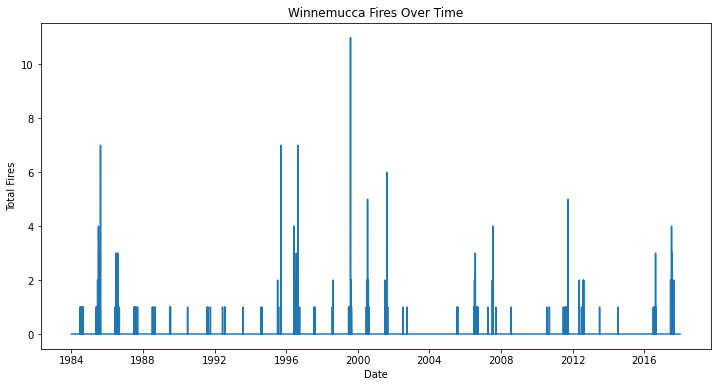

In [22]:
plt.figure(figsize=(12,6))
sns.lineplot('Date', 'Total_fires', data = Winn_df)
plt.title('Winnemucca Fires Over Time')
plt.xlabel('Date')
plt.ylabel('Total Fires')
plt.show()

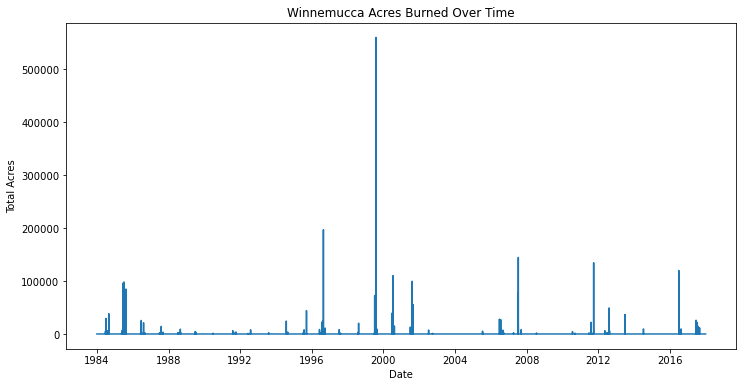

In [23]:
plt.figure(figsize=(12,6))
sns.lineplot('Date', 'Total_acres', data = Winn_df)
plt.title('Winnemucca Acres Burned Over Time')
plt.xlabel('Date')
plt.ylabel('Total Acres')
plt.show()

In [24]:
Winn_df.set_index('Date', inplace=True)
df1 = Winn_df[['tmax', 'tmin']].resample('W').mean()
df2 = Winn_df[['prcp','Total_fires','Total_acres' ]].resample('W').sum()
df3 = Winn_df[['last_rain', 'heat_wave']].resample('W').max()

In [25]:
df = pd.merge(df1,df2, on = 'Date', how='left')
df = pd.merge(df,df3, on = 'Date', how= 'left')

In [26]:
df.head()

,tmax,tmin,prcp,Total_fires,Total_acres,last_rain,heat_wave
Date,,,,,,,
1984-01-01,32.000000,12.000000,0.00,0.0,0.0,1,0
1984-01-08,27.857143,22.000000,0.00,0.0,0.0,8,0
1984-01-15,30.714286,13.571429,0.01,0.0,0.0,12,0
1984-01-22,28.857143,5.428571,0.08,0.0,0.0,5,0
1984-01-29,42.714286,18.857143,0.02,0.0,0.0,4,0


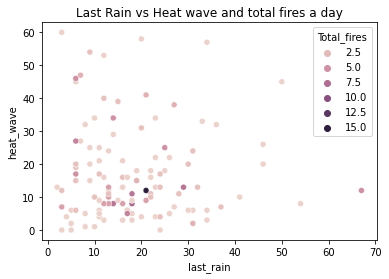

In [27]:
sns.scatterplot(x='last_rain', y= 'heat_wave', hue = 'Total_fires', data = df.loc[df['Total_fires']>0])
plt.title('Last Rain vs Heat wave and total fires a day')
plt.show()

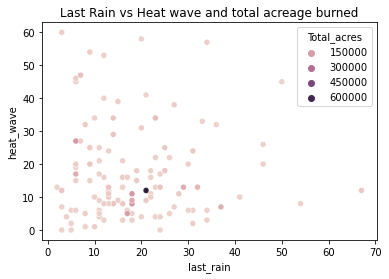

In [28]:
sns.scatterplot(x='last_rain', y= 'heat_wave', hue = 'Total_acres', data = df.loc[df['Total_fires']>0])
plt.title('Last Rain vs Heat wave and total acreage burned')
plt.show()

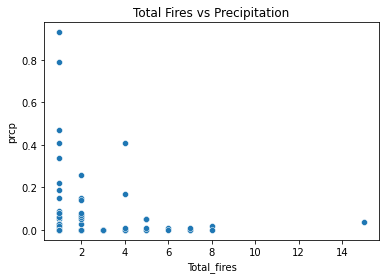

In [29]:
sns.scatterplot(y='prcp', x= 'Total_fires', data = df.loc[df['Total_fires']>0])
plt.title('Total Fires vs Precipitation')
plt.show()

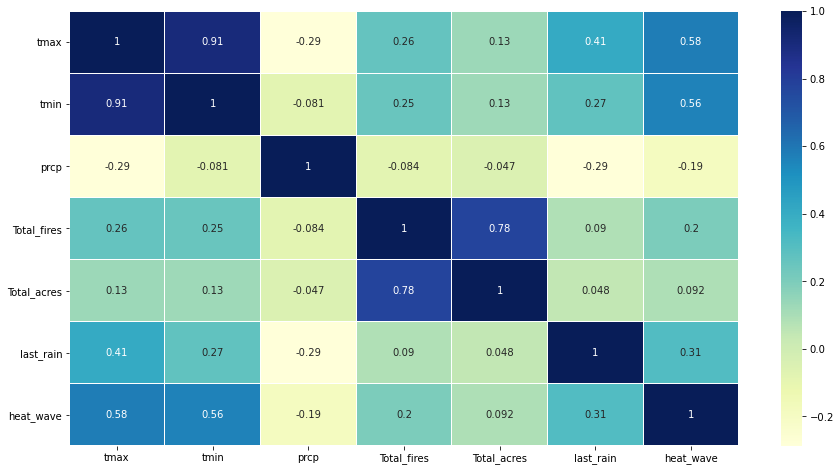

In [30]:
fig = plt.figure(figsize=(15,8))
sns.heatmap(df.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0)
plt.show()
